# 使用 LangGraph 构建旅行规划器：教程

## 概述

本教程指导您完成使用 LangGraph 创建简单旅行规划器的过程。LangGraph 是一个用于使用语言模型构建有状态、多步骤应用程序的库。该旅行规划器演示了如何构建一个收集用户输入并生成个性化旅行路线的对话式 AI 应用程序。

## 动机

在 AI 应用程序领域，管理多步骤过程中的状态和流程可能具有挑战性。LangGraph 提供了一种解决方案，允许开发人员创建基于图的工作流，可以在处理复杂交互的同时保持清晰和模块化的结构。此旅行规划器作为一个实际示例，展示了如何利用 LangGraph 的功能来构建有用且交互式的应用程序。

## 关键组件

1. **StateGraph**：我们应用程序的核心，定义了旅行规划器的流程。
2. **PlannerState**：表示规划过程状态的自定义类型。
3. **节点函数**：规划过程中的各个步骤（输入城市、输入兴趣、创建路线）。
4. **LLM 集成**：利用语言模型生成最终路线。

## 方法详情

我们的旅行规划器遵循一个简单的三步过程：

1. **城市输入**：
   - 应用程序提示用户输入他们想访问的城市。
   - 此信息存储在状态中。

2. **兴趣输入**：
   - 要求用户提供他们对旅行的兴趣。
   - 这些兴趣作为列表存储在状态中。

3. **路线创建**：
   - 使用收集到的城市和兴趣，应用程序利用语言模型生成个性化的一日游路线。
   - 生成的路线将呈现给用户。

这些步骤之间的流程由 LangGraph 管理，它处理状态转换并确保每个步骤按正确的顺序执行。

## 结论

本教程演示了如何使用 LangGraph 创建一个简单而有效的旅行规划器。通过将我们的应用程序构建为互连节点的图，我们实现了清晰的关注点分离和易于修改的工作流。这种方法可以扩展到更复杂的应用程序，展示了基于图的设计在 AI 驱动的对话界面中的强大功能和灵活性。

旅行规划器是开发人员构建使用语言模型的更复杂有状态应用程序的起点。它说明了状态管理、用户输入处理和与 AI 模型集成等关键概念，所有这些都在 LangGraph 提供的框架内。

### 设置和导入

首先，让我们导入必要的模块并设置我们的环境。

In [127]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image
from dotenv import load_dotenv
import os
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

### 定义代理状态

我们将定义代理在其整个操作过程中将维护的状态。

In [64]:
class PlannerState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "The messages in the conversation"]
    city: str
    interests: List[str]
    itinerary: str

### 设置语言模型和提示


In [122]:
llm = ChatOpenAI(model="gpt-4o-mini")


itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my day trip."),
])

### 定义代理函数

现在我们将定义代理将使用的主要函数：获取城市、获取兴趣、创建路线

In [123]:
def input_city(state: PlannerState) -> PlannerState:
    print("Please enter the city you want to visit for your day trip:")
    user_message = input("Your input: ")
    return {
        **state,
        "city": user_message,
        "messages": state['messages'] + [HumanMessage(content=user_message)],
    }

def input_interests(state: PlannerState) -> PlannerState:
    print(f"Please enter your interests for the trip to {state['city']} (comma-separated):")
    user_message = input("Your input: ")
    return {
        **state,
        "interests": [interest.strip() for interest in user_message.split(',')],
        "messages": state['messages'] + [HumanMessage(content=user_message)],
    }

def create_itinerary(state: PlannerState) -> PlannerState:
    print(f"Creating an itinerary for {state['city']} based on interests: {', '.join(state['interests'])}...")
    response = llm.invoke(itinerary_prompt.format_messages(city=state['city'], interests=", ".join(state['interests'])))
    print("\nFinal Itinerary:")
    print(response.content)
    return {
        **state,
        "messages": state['messages'] + [AIMessage(content=response.content)],
        "itinerary": response.content,
    }

### 创建并编译图

现在我们将创建 LangGraph 工作流并对其进行编译。

In [124]:
workflow = StateGraph(PlannerState)

workflow.add_node("input_city", input_city)
workflow.add_node("input_interests", input_interests)
workflow.add_node("create_itinerary", create_itinerary)

workflow.set_entry_point("input_city")

workflow.add_edge("input_city", "input_interests")
workflow.add_edge("input_interests", "create_itinerary")
workflow.add_edge("create_itinerary", END)

app = workflow.compile()

### 显示图结构

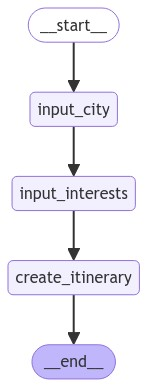

In [119]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### 定义运行图的函数

In [125]:
def run_travel_planner(user_request: str):
    print(f"Initial Request: {user_request}\n")
    state = {
        "messages": [HumanMessage(content=user_request)],
        "city": "",
        "interests": [],
        "itinerary": "",
    }
    
    for output in app.stream(state):
        pass  # The nodes themselves now handle all printing

### 用例示例

In [126]:
user_request = "I want to plan a day trip."
run_travel_planner(user_request)

Initial Request: I want to plan a day trip.

Please enter the city you want to visit for your day trip:


Please enter your interests for the trip to paris (comma-separated):
Creating an itinerary for paris based on interests: food...

Final Itinerary:
Here’s a delightful food-focused day trip itinerary for Paris:

### Morning
- **8:30 AM: Breakfast at Café de Flore**
  - Enjoy a classic French breakfast of croissants, café au lait, and fresh orange juice.

- **9:30 AM: Visit a Local Bakery (Boulangerie)**
  - Stop by **Du Pain et des Idées** for a taste of their famous pain des amis or pistachio croissant.

### Late Morning
- **10:30 AM: Explore Le Marais District**
  - Stroll through the charming streets and pop into specialty food shops, such as **La Maison Plisson** for gourmet snacks.

### Lunch
- **12:00 PM: Lunch at L'As du Fallafel**
  - Savor the best falafel in Paris at this popular spot in Le Marais. Don’t forget to try their famous tahini sauce!

### Afternoon
- **1:30 PM: Visit the Marché Bastille**
  - Explore this vibrant market (open on Sundays) for fresh produce, artisanal

## 运行代理

现在让我们用一个示例请求来运行我们的代理！